# COVID-19 Anxiety Monitor
Aim:
- Scrape London-based Tweets related to #Coronavirus
- Apply Vader to run Sentiment Analysis
- Chart Sentiment over the period vs. Virus: How have Londoners' attitudes changed as the virus progressed?

## Import packages

In [1]:
import GetOldTweets3 as got
from tqdm.notebook import tqdm
import sys
import time
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
from sklearn.feature_extraction import DictVectorizer
import scipy.stats as stats
import statsmodels.api as sm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from wordcloud import WordCloud, STOPWORDS
import re

In [2]:
def getoldtweets(since, until, query, near='London, UK', lang='en', maxtweets=10000):
    '''Wrap TweetCriteria class in a function to enable dynamic setting of variables when called'''
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('{}'.format(query))\
                                           .setSince('{}'.format(since))\
                                           .setUntil('{}'.format(until))\
                                           .setNear('{}'.format(near))\
                                           .setLang('{}'.format(lang))\
                                           .setMaxTweets(maxtweets)
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets

def spacy_text_processor(text_col, pos=['PROPN']):
    '''Clean punctuation and tokenize tweets. Filter tokens by token.pos_ specified. Entity Recognition'''
    
    nlp = spacy.load('en_core_web_sm')

    persons = [('boris johnson','johnson'),('boris','johnson'),('johnson','johnson'),('prime minister','johnson'),
               ('primeminister','johnson'),('matt','hancock'),('hancock','hancock'),('matt hancock','hancock'),
               ('health secretary','hancock'),('healthsecretary','hancock')]
    orgs = [('nhs','nhs'),('government','government')]
    
    tokens = []
    people = []
    organisations = []
    custom_people = []
    custom_organisations = []

    for parsed in tqdm(nlp.pipe(text_col)):
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()

        tokens.append(doc_)

        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                if ent.label_ == 'PERSON':
                    named_persons += ent.text + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.text + ''
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''

        people.append(named_persons)
        organisations.append(named_orgs)
        
    ruler_boris = EntityRuler(nlp, overwrite_ents=True)
    ruler_orgs = EntityRuler(nlp, overwrite_ents=True)

    for (p,i) in persons:
        ruler_boris.add_patterns([{"label": "PERSON", "pattern": [{"LOWER": p}], "id": i}])
    for (o,i) in orgs:
        ruler_orgs.add_patterns([{"label": "ORG", "pattern": [{"LOWER": o}], 'id': i}])

    ruler = EntityRuler(nlp)
    ruler.add_patterns(ruler_orgs.patterns)
    ruler.add_patterns(ruler_boris.patterns)

    nlp.add_pipe(ruler)

    for parsed in tqdm(nlp.pipe(text_col, disable=['ner'])):
        if parsed.ents:
            for ent in parsed.ents:
                custom_persons = ''
                custom_orgs = ''
                if ent.label_ == 'PERSON':
                    custom_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    custom_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            custom_persons = ''
            custom_orgs = ''

        custom_persons = custom_persons.strip()
        custom_orgs = custom_orgs.strip()

        custom_people.append(custom_persons)
        custom_organisations.append(custom_orgs)
        
    return tokens, people, organisations, custom_people, custom_organisations

def vader_scorer(df):
    '''Compute vaderSentiment scores for each tweet
    Args: Dataframe containing a 'text' column
    Returns: Dataframe of vader scores
    '''
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores

def tweet_postproc_tocsv(tweets_dictionary):
    '''Applying NLP post-processing to newly retrieved tweets, and save to csv file, one for each date queried
    Args: a dictionary of tweet objects, each key pertaining to each date queried for
    Returns: nothing. Output is saved in a directory of tweet .csv files for import during analysis
    '''
    for query_date in list(tweets_dictionary.keys()):
        tweets_df = []
        for tweet in tweets_dictionary[query_date]:
            tweets_df.append([tweet.username, tweet.id, tweet.date, tweet.favorites, tweet.hashtags,
                              tweet.mentions, tweet.retweets, tweet.replies, tweet.text])

        tweets_df = pd.DataFrame(tweets_df,columns=['username','tweet_id','date','favorites','hashtags',
                                                    'mentions','retweets','replies','text'])

        propn_string, people, orgs, topical_persons, topical_orgs = spacy_text_processor(tweets_df['text'])

        pd.options.mode.chained_assignment = None

        tweets_df['topical_persons'] = topical_persons
        tweets_df['topical_orgs'] = topical_orgs
        tweets_df['persons'] = people
        tweets_df['orgs'] = orgs
        tweets_df['propn'] = propn_string

        vader_scores = vader_scorer(tweets_df)
        tweets_df = pd.concat([tweets_df,vader_scores], axis=1)

        tweets_df = tweets_df.drop_duplicates(subset='tweet_id', ignore_index=True)
        tweets_df.to_csv('./data/tweets_{}.csv'.format(query_date), index=False)

def csv_compiler(folder='./data/tweets_*.csv'):
    '''Import files as specified in input and collate into one DataFrame
    Args: folder, str. filepath relative to current folder, with optional pattern recognition
    Returns: DataFrame of collated data
    '''
    df = pd.concat([pd.read_csv('{}'.format(filepath), parse_dates=['date']) for filepath in glob.iglob(folder)],
                   ignore_index=True)
    df.sort_values("date", inplace=True)
    df.drop_duplicates(subset="tweet_id", ignore_index=True, inplace=True)
    return df

## Search for tweets
- Twitter Official API has time constraints, you can't get older tweets than a week. 
- Some tools provide access to older tweets but in the most of them you have to spend some money before.
- GetOldTweets3 mimics a Twitter search so we can search older tweets: when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider.

In [3]:
start = '2020-05-20'
until = (datetime.today()-timedelta(days=1)).date()
datelist = pd.date_range(start, end=until).tolist()
query = 'coronavirus OR covid OR covid-19 OR covid19'
sleep_mins = 16
max_attempts = 3

tweets_dict = {}

error = None
for (i,date) in tqdm(enumerate(datelist)):
    attempts_at_date = 0
    if error != 'KeyboardInterrupt':
        if attempts_at_date < max_attempts:
            while True:
                if attempts_at_date < max_attempts:
                    attempts_at_date += 1
                    try:
                        print('\nAttempt {} of {} retrieving {}'\
                              .format(attempts_at_date, max_attempts, str(date)[:10]))
                        tweets_dict[str(date)[:10]] = getoldtweets(str(date)[:10],
                                                                   str(date+timedelta(days=1))[:10],
                                                                   query)
                        num_tweets = len(tweets_dict[str(date)[:10]])
                        print('Success retrieving {} tweets for {}: {} of {} dates'\
                              .format(num_tweets,str(date)[:10],i+1,len(datelist)))
                        break

                    except KeyboardInterrupt:
                        error = 'KeyboardInterrupt'
                        break

                    except:
                        try:
                            print('\nError retrieving {} on attempt {} of {}. Sleeping for {} minutes.\nMinutes Slept:'\
                                  .format(str(date)[:10], attempts_at_date, max_attempts, sleep_mins))
                            for t in range(sleep_mins+attempts_at_date):
                                sys.stdout.write(str(t) + '.. ')
                                sys.stdout.flush()
                                time.sleep(60)
                        except KeyboardInterrupt:
                            break
                else:
                    print('Attempt {} at {} failed. Exiting.'.format(max_attempts, str(date)[:10]))
                    break
        else:
            break
    else:
        break

tweets_ls = []
for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        tweets_ls.append(tweet)

print('\nTotal No. Tweets retrieved: {}'.format(len(tweets_ls)))


Attempt 1 of 3 retrieving 2020-05-20
An error occured during an HTTP request: HTTP Error 503: Service Temporarily Unavailable
Try to open in browser: https://twitter.com/search?q=coronavirus%20OR%20covid%20OR%20covid-19%20OR%20covid19%20near%3A%22London%2C%20UK%22%20within%3A15mi%20since%3A2020-05-20%20until%3A2020-05-21&src=typd

Error retrieving 2020-05-20 on attempt 1 of 3. Sleeping for 16 minutes.
Minutes Slept:
0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 

Total No. Tweets retrieved: 0


## Post-processing
- spaCy Entity Recognition to parse Proper Nouns, and spaCy nlp pipeline's Entity Ruler also used to understand main themes present in tweets
- Vader sentiment scoring for each tweet
- Save .to_csv that date's processsed tweets

In [446]:
tweet_postproc_tocsv(tweets_dict)

## Sentiment Analysis

VaderSentiment metrics explained:
- Pos: Proportion of the text that falls into the positive category: ie. no.pos words / total no.words
- Neu: Proportion of the text that falls into the neutral category: ie. no.neu words / total no.words
- Neg: Proportion of the text that falls into the negative category: ie. no.neg words / total no.words

... so these 3 metrics should up to 1 for a given text

- Compound: Summing the valence scores of each word in the text, and normalized to between -1 (neg) and 1 (pos). 
  - This gives us a polarity measure for that text.
  - It's normalized so can be used to compare different texts
  - Note - researchers usually use +/-0.05 as the threshold between neutral and polar texts

### Compile tweets, load case data
Collate daily tweets.csv files into one large DataFrame for analysis below

In [4]:
tweets = csv_compiler()

cases = pd.read_csv('./data/UKDailyConfirmedCases.csv')
cases['DateVal'] = pd.to_datetime(cases['DateVal'], format='%d/%m/%Y')
cases.rename(columns={'CMODateCount':'DailyCases'}, inplace=True)

### Sentiment Progression by date

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


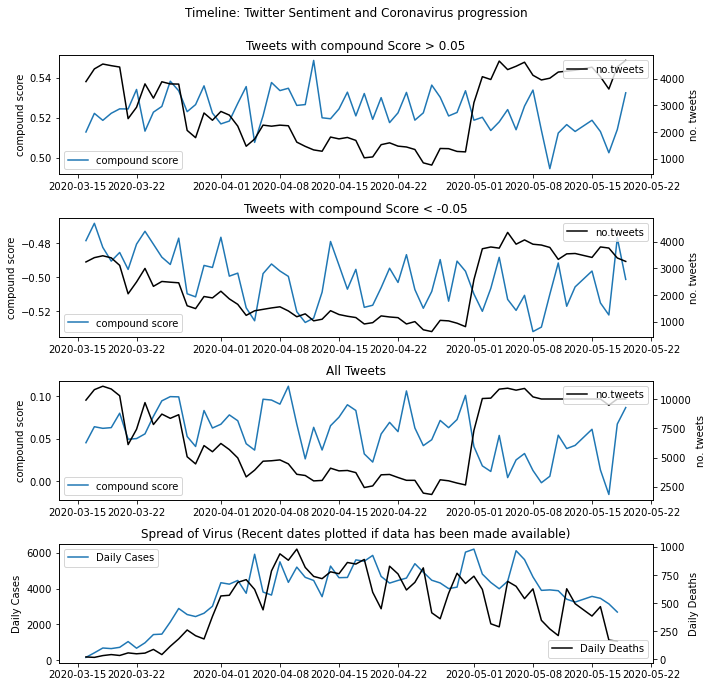

In [5]:
'''Group Sentiment Data by Date and plot alongside no.cases'''

start_date = '2020-03-16' # Choose date to start plotting from
score = 'compound' # Choose sentiment metric
pos_threshold = 0.05 # Choose threshold for positive valence
neg_threshold = -0.05 # Choose threshold for negative valence

'''Filter for valences to plot'''
tweets_pos_valence = tweets[(tweets['{}'.format(score)]>pos_threshold)]
tweets_neg_valence = tweets[(tweets['{}'.format(score)]<neg_threshold)]

'''Merge with no.cases data'''
tweets_pos_valence = tweets_pos_valence.set_index('date').groupby(tweets_pos_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_neg_valence = tweets_neg_valence.set_index('date').groupby(tweets_neg_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_all_valence = tweets.set_index('date').groupby(tweets.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})

cases_plt = cases.set_index('DateVal')
cases_plt['DailyCases_shifted_1'] = cases_plt.DailyCases.shift(1)
cases_plt['DailyDeaths_shifted_1'] = cases_plt.DailyDeaths.shift(1)

tweets_pos_valence = pd.merge(tweets_pos_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_neg_valence = pd.merge(tweets_neg_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_all_valence = pd.merge(tweets_all_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

'''Filter for dates to plot'''
tweets_pos_valence = tweets_pos_valence[tweets_pos_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_neg_valence = tweets_neg_valence[tweets_neg_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_all_valence = tweets_all_valence[tweets_all_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]

'''Plot'''
fig, ax = plt.subplots(figsize=(10,10), sharex=True)
fig.suptitle('Timeline: Twitter Sentiment and Coronavirus progression')

# add subplots to current figure and assign them to variables
ax0 = plt.subplot(411)
ax1 = ax0.twinx()
ax2 = plt.subplot(412)
ax3 = ax2.twinx()
ax4 = plt.subplot(413)
ax5 = ax4.twinx()
ax6 = plt.subplot(414)
ax7 = ax6.twinx()

# share y-axes for no.tweets, and share x-axes for all plots to align dates:
ax1.get_shared_y_axes().join(ax1, ax3)
ax1.get_shared_x_axes().join(ax1, ax3, ax5, ax7)

# Plot data on their respective axes:
ax0.plot(tweets_pos_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax0.set_ylabel('{} score'.format(score))
ax0.legend(loc='lower left')
ax0.set_title('Tweets with {} Score > {}'.format(score,pos_threshold))

ax1.plot(tweets_pos_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax1.set_ylabel('no. tweets')
ax1.legend(loc='upper right')

ax2.plot(tweets_neg_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax2.set_ylabel('{} score'.format(score))
ax2.legend(loc='lower left')
ax2.set_title('Tweets with {} Score < {}'.format(score,neg_threshold))

ax3.plot(tweets_neg_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax3.set_ylabel('no. tweets')
ax3.legend(loc='upper right')

ax4.plot(tweets_all_valence[('{}'.format(score),'mean')], label='{} score'.format(score))
ax4.set_ylabel('{} score'.format(score))
ax4.legend(loc='lower left')
ax4.set_title('All Tweets')

ax5.plot(tweets_all_valence[('{}'.format(score),'count')], label='no.tweets', c='k')
ax5.set_ylabel('no. tweets')
ax5.legend(loc='upper right')

ax6.plot(tweets_neg_valence['DailyCases'], label='Daily Cases')
ax6.set_ylabel('Daily Cases')
ax6.legend(loc='upper left')
ax6.set_title('Spread of Virus (Recent dates plotted if data has been made available)')

ax7.plot(tweets_neg_valence['DailyDeaths'], label='Daily Deaths', c='k')
ax7.set_ylabel('Daily Deaths')
ax7.set_ylabel('Daily Deaths')
ax7.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

### Correlations: Sentiment vs Disease Progression
Summary:
- The Correlation matrix below suggests an increase in no.tweets and also higher negative valence as the cases and deaths increased.
- Introducing a 1-day lag increases this correlation, suggesting a lagged effect of the effect on sentiment of the disease
- We also visualise this through scatter plots further below

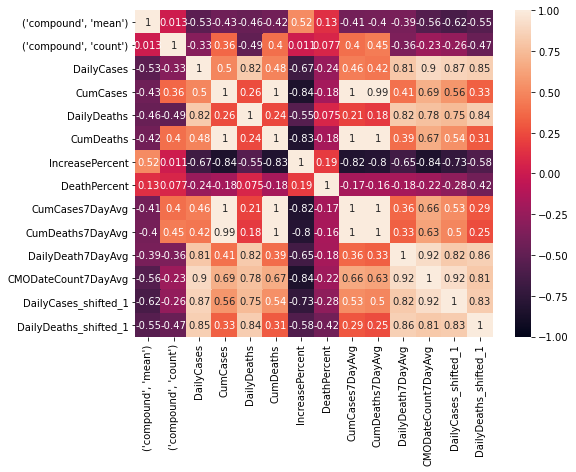

In [6]:
'''HeatMap of Correlations'''
plt.figure(figsize=(8,6))
sns.heatmap(tweets_neg_valence.iloc[1:,:].corr(), vmin=-1, vmax=1, annot=True);

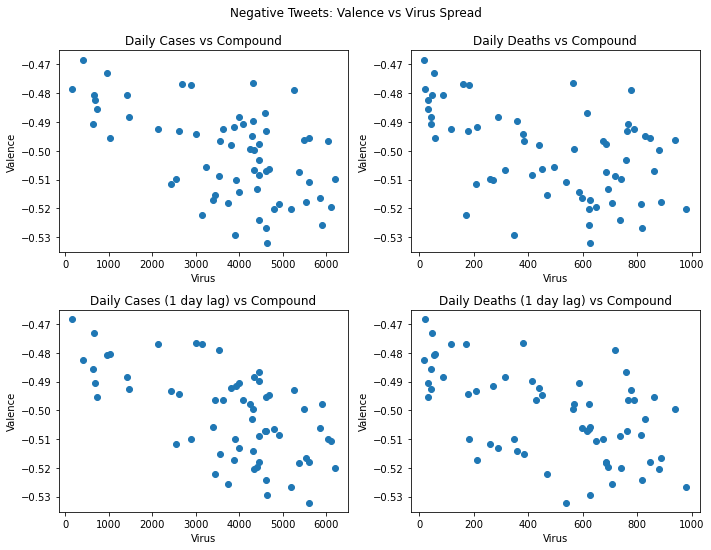

In [7]:
'''Scatter Plots of Valence of Negative Tweets vs Cases and Deaths'''

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.suptitle('Negative Tweets: Valence vs Virus Spread')

ax[0,0].scatter(tweets_neg_valence['DailyCases'],tweets_neg_valence[('compound','mean')])
ax[0,0].set_xlabel('Virus')
ax[0,0].set_ylabel('Valence')
ax[0,0].set_title('Daily Cases vs Compound')

ax[0,1].scatter(tweets_neg_valence['DailyDeaths'],tweets_neg_valence[('compound','mean')])
ax[0,1].set_xlabel('Virus')
ax[0,1].set_ylabel('Valence')
ax[0,1].set_title('Daily Deaths vs Compound')

ax[1,0].scatter(tweets_neg_valence.iloc[1:,-2],tweets_neg_valence.iloc[1:,0])
ax[1,0].set_xlabel('Virus')
ax[1,0].set_ylabel('Valence')
ax[1,0].set_title('Daily Cases (1 day lag) vs Compound')

ax[1,1].scatter(tweets_neg_valence.iloc[1:,-1],tweets_neg_valence.iloc[1:,0])
ax[1,1].set_xlabel('Virus')
ax[1,1].set_ylabel('Valence')
ax[1,1].set_title('Daily Deaths (1 day lag) vs Compound')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

It appears there's some correlation between valence and the disease's progression given the heatmap above which suggested a ~50% correlation, and given the visual distribution of data in the scatter plots, below we formally linearly regress to confirm this

In [281]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [282]:
def regression_scorer(df, num_rows, x_iloc, y_iloc):
    X = np.array(df.iloc[:num_rows,x_iloc]).reshape(-1,1)
    y = np.array(df.iloc[:num_rows,y_iloc]).reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    pipeline = make_pipeline(StandardScaler(), LinearRegression())
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_test, y_test)

def plot_regression_trend(df, x_iloc, y_iloc):
    num_days_regressed = range(22, len(df)+1)
    scores = [regression_scorer(df, i, x_iloc, y_iloc) for i in num_days_regressed]
    plt.plot(num_days_regressed, scores)
    plt.title('Negative Tweets vs {}'.format(df.columns[x_iloc]))
    plt.xlabel('Num Days in Regression')
    plt.ylabel('Average Valence')

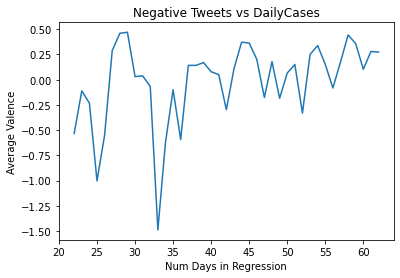

In [283]:
plot_regression_trend(tweets_neg_valence, 2, 0)

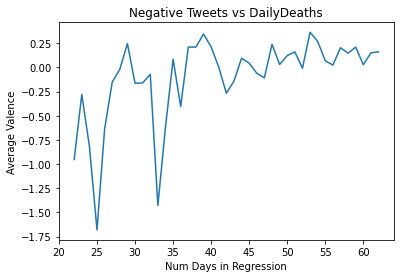

In [284]:
plot_regression_trend(tweets_neg_valence, 4, 0)

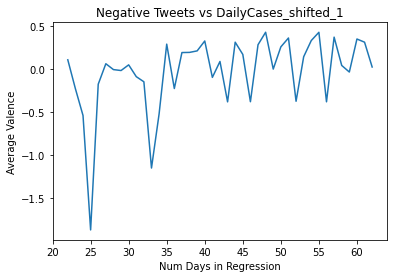

In [285]:
plot_regression_trend(tweets_neg_valence, 12, 0)

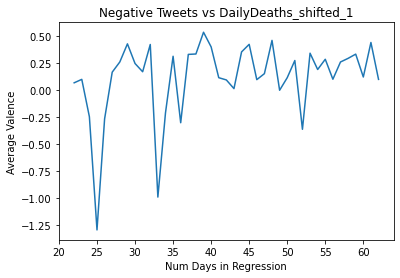

In [286]:
plot_regression_trend(tweets_neg_valence, 13, 0);

##### Conclusion
Above I have plotted the progression in the regression score as I included more days in the model, ie. as the virus progressed:
- At the outset, the regression scores were unstable from one to the day, and often showed values < -1.
- As time passed the behaviour stabilised, however the score oscillated around 0 for all 4 measures of virus progression that I looked at, indicating no strong correlation that we can quantify mathematically.
- Looking again at the trend in virus progression, vs the trend in overall negative sentiment: it's clear to see that despite large swings in the number of cases and deaths, the average valence in negative tweets was relatively unchanged.
- This confirms previous findings that as you zoom out, and include more tweets in your dataset, the sentiment tends to remain stable a at a mean value.
- It's better advised to use sentiment analysis to compare distribution of sentiment for different subsets of the population of the tweets, as we turn to below in Thematic Sentiment

### Themes of immediate interest
- First I turn to specific entities of interest, namely Boris Johnson the Prime Minister, Matt Hancock the Health Secretary, the Government, and the NHS.
- I used spaCy's custom entity recognizer to set up EntityRulers that retrieve these specific entities for me, in the post-processing step after tweet retrieval (above)
- I am then able to find those tweets referencing each of these topics, and conduct comparative sentiment analysis

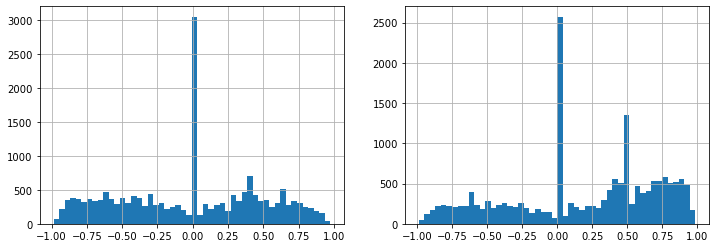

In [322]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
tweets[tweets.topical_orgs=='government']['compound'].hist(ax=ax[0], bins=50)
tweets[tweets.topical_orgs=='nhs']['compound'].hist(ax=ax[1], bins=50);

The NHS distribution is skewed to the right, so we hypothesise:
#### Hypothesis 1: Null Hypothesis is that sentiment for the NHS and the Government was the same

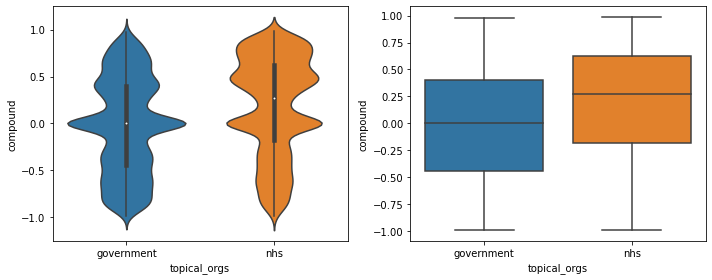

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.violinplot(y='compound', x='topical_orgs', data=tweets[tweets.topical_orgs != ''], ax=ax[0])
sns.boxplot(y='compound', x='topical_orgs', data=tweets[tweets.topical_orgs != ''], ax=ax[1])
plt.tight_layout();

We will compare the sample means using a t-test, it assumed standard deviation for both samples is the same:
- the IQRs in the boxplot are roughly the same size for both distributions, which points to this fact
- we also confirm this here:

In [328]:
print('StDev of Gov sentiment',np.std(np.array(tweets[tweets.topical_orgs == 'government']['compound'])))
print('StDev of NHS sentiment',np.std(np.array(tweets[tweets.topical_orgs == 'nhs']['compound'])))

StDev of Gov sentiment 0.5022993366891237
StDev of NHS sentiment 0.5245510723953112


Running SciPy's t-test:
- Note: had sample standard deviations not been equal, then set equal_var = False to use Welch's t-statistic

In [329]:
stats.ttest_ind(tweets[tweets.topical_orgs == 'government']['compound'],
                tweets[tweets.topical_orgs == 'nhs']['compound'])

Ttest_indResult(statistic=-37.42015489753647, pvalue=1.2971579249297571e-300)

We can construct a 95% confidence interval for our difference in sample means to further confirm this:

In [44]:
p_gov = np.mean(tweets[tweets.topical_orgs == 'government']['compound'])
p_nhs = np.mean(tweets[tweets.topical_orgs == 'nhs']['compound'])

num_gov = len(tweets[tweets.topical_orgs == 'government'])
num_nhs = len(tweets[tweets.topical_orgs == 'nhs'])

The s.e. for each population (as we're comparing MEANS here) is simply: $\sigma / \sqrt{n}$

In [45]:
se_gov = np.std(tweets[tweets.topical_orgs == 'government']['compound']) / np.sqrt(num_gov)
se_nhs = np.std(tweets[tweets.topical_orgs == 'nhs']['compound']) / np.sqrt(num_nhs)

With the standard error for both populations to be used in CI formula below: $SE = \sqrt{(SE_{\ 1})^2 + (SE_{\ 2})^2}$

In [46]:
se_diff = np.sqrt(se_gov**2 + se_nhs**2)

In [43]:
diff = p_gov - p_nhs
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(-0.21567477509080404, -0.1946999608361962)

- We are 95% confident that average sentiment for government is lower than for the NHS
- We can also plot how this CI varied over time:

#### Verdict
- The very low p-value gives us good confidence in Rejecting the Null Hypothesis.
- Judging from the plots, and mean sentiments, tweets regarding the NHS were more positive than for the Government.

#### Explanation

The low standard error for both distributions led us to have a high confidence in rejecting the null:

In [10]:
print('Gov sentiment s.e.', stats.sem(tweets[tweets.topical_orgs == 'government']['compound'], axis=None))
print('NHS sentiment s.e.', stats.sem(tweets[tweets.topical_orgs == 'nhs']['compound'], axis=None))

Gov sentiment s.e. 0.003658893871065916
NHS sentiment s.e. 0.0039043862431747903


Looking at the below distplot, there were both more positive tweets and fewer negative tweets for the NHS vs the Government:

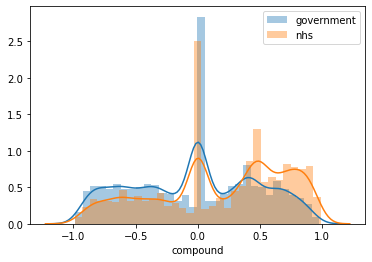

In [13]:
sns.distplot(tweets[tweets.topical_orgs == 'government']['compound'], label='government')
sns.distplot(tweets[tweets.topical_orgs == 'nhs']['compound'], label='nhs')
plt.legend();

If this is statistically significant, this would be a good explanation. We check for this by constructing a confidence interval for the difference between the two population proportions (% pos tweets, and % neg tweets)
1. Positive tweets:

As you will see here: as the population parameter we are comparing isn't a mean this time, the standard error formula changes from:
<br>
<br>
$\sigma / \sqrt{n}$
<br>
<br>
to:
<br>
<br>
$\sqrt{p(1-p) / n}$

In [27]:
p_gov = len(tweets[(tweets.topical_orgs == 'government') & (tweets.compound > 0.05)]) / len(tweets[tweets.topical_orgs == 'government'])
num_gov = len(tweets[tweets.topical_orgs == 'government'])
se_gov = np.sqrt(p_gov * (1-p_gov) / num_gov)

print(p_gov, num_gov, se_gov)

0.40296296296296297 18900 0.0035678147791856117


In [28]:
p_nhs = len(tweets[(tweets.topical_orgs == 'nhs') & (tweets.compound > 0.05)]) / len(tweets[tweets.topical_orgs == 'nhs'])
num_nhs = len(tweets[tweets.topical_orgs == 'nhs'])
se_nhs = np.sqrt(p_nhs * (1-p_nhs) / num_nhs)

print(p_nhs, num_nhs, se_nhs)

0.5657938533229779 18026 0.0036917085952754484


We have the s.e. for each population (gov vs nhs), now the s.e. of the difference of two population parameters is:
$SE = \sqrt{(SE_{\ 1})^2 + (SE_{\ 2})^2}$
<br>
which will always be greater than the individual populations, it's a combination of them both

In [34]:
se_diff = np.sqrt(se_gov**2 + se_nhs**2)
se_diff

0.005134005712015317

We now have what we need to calculate the 95% confidence interval for the difference in population proportion of positive tweets:

In [35]:
diff = p_gov - p_nhs
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(-0.172893541555565, -0.15276823916446494)

- We can see with 95% confidence that tweets re. Government had a lower proportion of positive than tweets re: NHS.
- Let's also check the same for difference in negative tweets proportion.
    - First letting p, the proportion parameter, now = negative tweets:

In [36]:
p_gov = len(tweets[(tweets.topical_orgs == 'government') & (tweets.compound < -0.05)]) / len(tweets[tweets.topical_orgs == 'government'])
p_nhs = len(tweets[(tweets.topical_orgs == 'nhs') & (tweets.compound < -0.05)]) / len(tweets[tweets.topical_orgs == 'nhs'])

Then calculating the confidence interval for the difference in proportion of negative tweets

In [37]:
diff = p_gov - p_nhs
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(0.12724484761422325, 0.1473701500053233)

We can also say with 95% confidence that tweets re. Government had a higher proportion of negative tweets than tweets re: NHS.

Can we visualise what type of sentiment people had for the Government vs the NHS? Let's look at the words that were being used to better understand how the public described each entity:

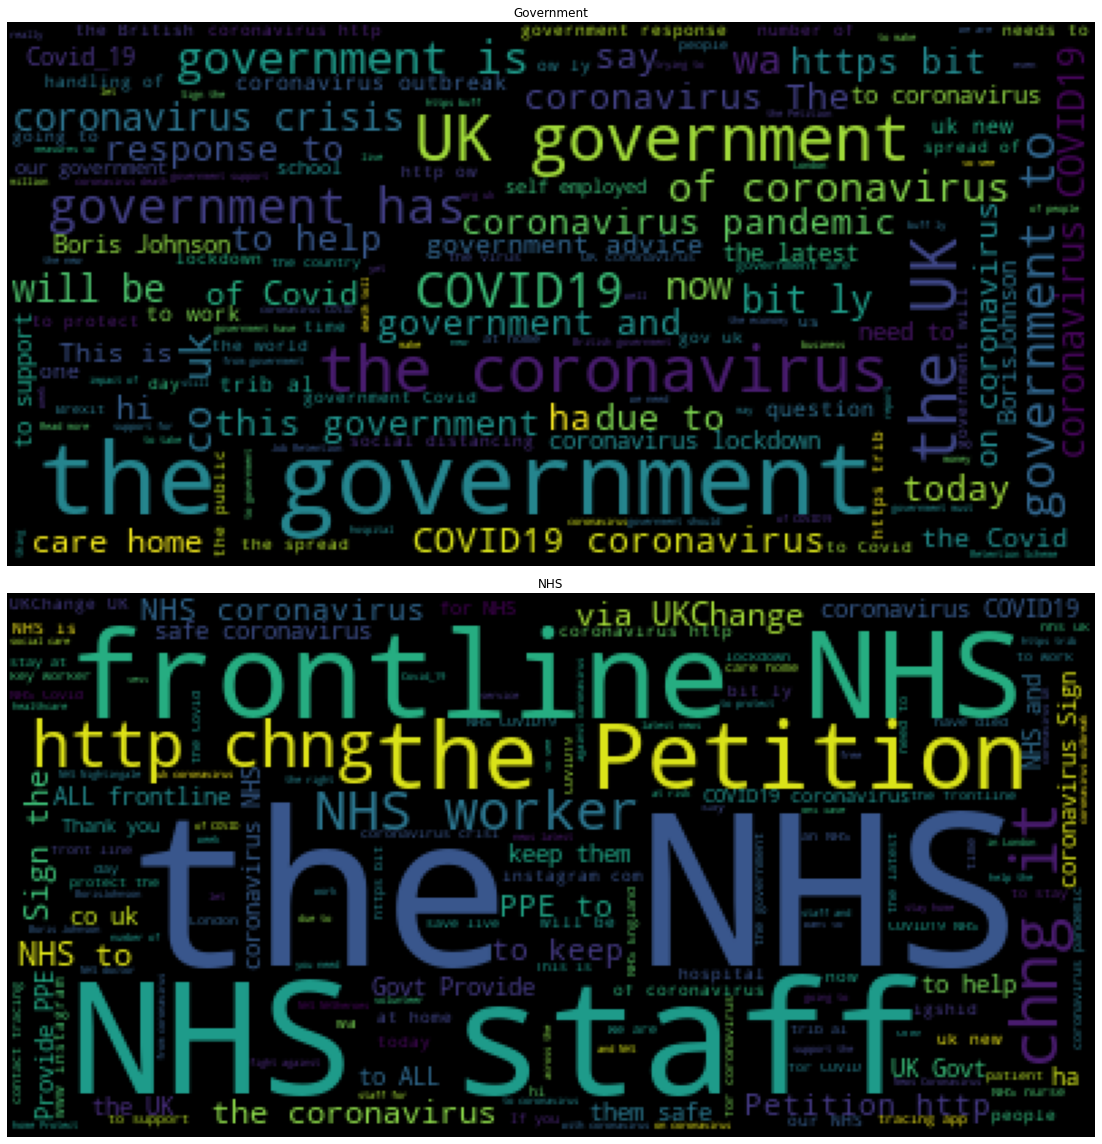

In [413]:
gov_text = " ".join(tweet for tweet in tweets.text[tweets.topical_orgs=='government'])
nhs_text = " ".join(tweet for tweet in tweets.text[tweets.topical_orgs=='nhs'])

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit'])

gov_wordcloud = WordCloud(stopwords=stopwords).generate(gov_text)
nhs_wordcloud = WordCloud(stopwords=stopwords).generate(nhs_text)

fig, ax = plt.subplots(nrows=2, figsize=(16,16))
ax[0].imshow(gov_wordcloud)
ax[0].set_title('Government')
ax[0].axis('off')
ax[1].imshow(nhs_wordcloud)
ax[1].set_title('NHS')
ax[1].axis('off')
plt.tight_layout();

It's not entirely clear to see what the public thought of the Government vs the NHS, as these wordclouds are dominated by oft-used words that were neutral in sentiment.
- I will take these corpora of words and pass them through my vader scorer
- Then filter for the most emotive words (positive or negative), and visualise only those words in wordclouds.

In [414]:
def emotive_filter(corpus):
    ''' Scores a corpus for sentiment.
    Args: corpus, str. One string containing the full list of words, with duplication in the sample set
    Returns: dataframe of vader scores only'''
    text_to_list = re.sub("[^\w]", " ",  corpus).split()
    list_to_df = pd.DataFrame(gov_text_list, columns=['text'])
    return vader_scorer(list_to_df)
    
gov_sentiment = emotive_filter(gov_text)
nhs_sentiment = emotive_filter(nhs_text)

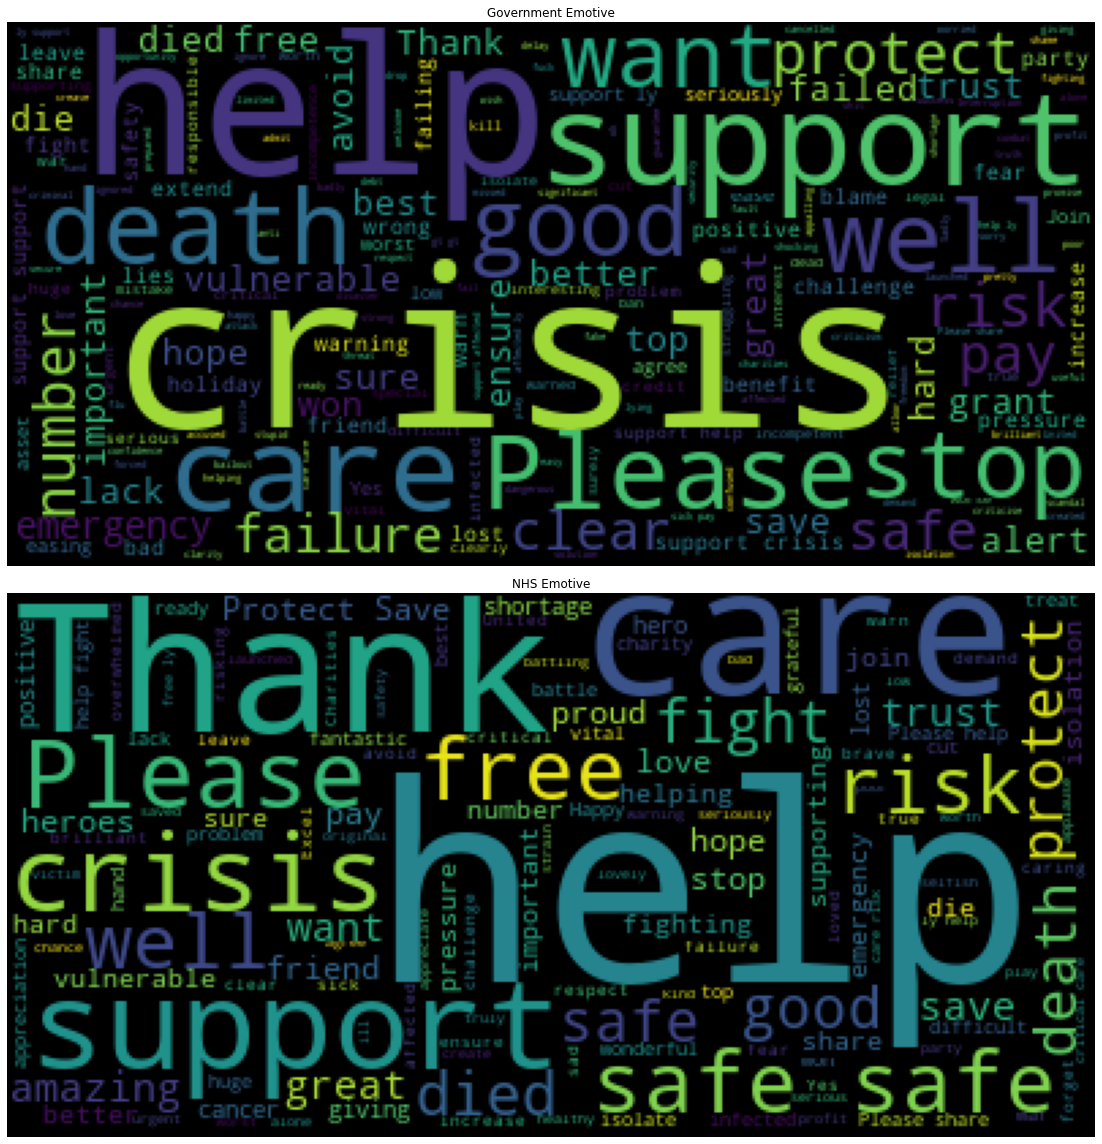

In [412]:
gov_emotive_words = gov_text_df[(gov_sentiment.compound<-0.05) | (gov_sentiment.compound>0.05)]
nhs_emotive_words = nhs_text_df[(nhs_sentiment.compound<-0.05) | (nhs_sentiment.compound>0.05)]

gov_emotive_wordcloud = WordCloud(stopwords=stopwords).generate(gov_emotive_words.to_string())
nhs_emotive_wordcloud = WordCloud(stopwords=stopwords).generate(nhs_emotive_words.to_string())

fig, ax = plt.subplots(nrows=2, figsize=(16,16))
ax[0].imshow(gov_emotive_wordcloud)
ax[0].set_title('Government Emotive')
ax[0].axis('off')
ax[1].imshow(nhs_emotive_wordcloud)
ax[1].set_title('NHS Emotive')
ax[1].axis('off')
plt.tight_layout();

These wordclouds give a clearer picture of why the NHS was seen more positively than the Government:
- Gov: tweeters reference the Government when highlighting perceived failures, rarely is there positive mention of government work.
    - crisis, failure, died, die, vulnerable, stop, failed, seriously, lack, emergency, hard, warning, failing

- NHS: tweets generally reference NHS as heroes for the support and care they give in such trying circumstances.
    - thank, care, support, well, help, safe, good, protect, love, helping, hope, friend, heroes, proud, great
    
It's interesting therefore that despite ostensibly working towards a common goal, the public it seems perhaps see the NHS as fighting it's battles better than the government has.

In [430]:
nhs_tweets = tweets[tweets.topical_orgs=='nhs']
nhs_grouped = nhs_tweets.groupby(nhs_tweets.set_index('date').index.date).agg({'compound':['mean','count']})
nhs_tweets_case = pd.merge(nhs_grouped, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [442]:
nhs_tweets_case[('compound','count')].sort_values().tail(10)

2020-05-05    380
2020-05-03    382
2020-05-06    393
2020-03-27    426
2020-04-08    428
2020-03-25    453
2020-04-02    488
2020-05-07    520
2020-04-01    582
2020-03-26    707
Name: (compound, count), dtype: int64

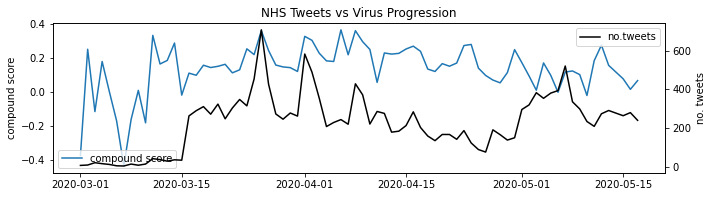

In [434]:
fig, ax = plt.subplots(figsize=(10,10), sharex=True)

ax0 = plt.subplot(411)
ax1 = ax0.twinx()

ax0.plot(nhs_tweets_case[('compound','mean')], label='compound score')
ax0.set_ylabel('compound score')
ax0.legend(loc='lower left')
ax0.set_title('NHS Tweets vs Virus Progression')

ax1.plot(nhs_tweets_case[('compound','count')], label='no.tweets', c='k')
ax1.set_ylabel('no. tweets')
ax1.legend(loc='upper right')
plt.tight_layout();

- Overall trend of NHS tweet sentiment has been quite steady at around +0.2
- There were 3 noticeable weekly peaks that were reducing in magnitude in terms of num_tweets, in line with the start of the Clap for NHS campaign which brought positive sentiment onto Twitter
- Although any bump in volume or sentiment of tweets from those weekly campaigns has largely subsided

In [447]:
# I want to find a good statistical procedure for sampling no.tweets such that it's equal across days

### Topical themes
- What other main talking points emerge over the period? Visualise this in a wordcloud
    - Of these main talking points, who were losers and winners?
    - How did sentiments towards talking points trend over time?
- Which persons or orgs were the big winners and big losers in terms of sentiment?
    - How did sentiments and also num_tweets re: these persons / orgs trend over time?